<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Data-Augmentation" data-toc-modified-id="Data-Augmentation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Augmentation</a></span></li><li><span><a href="#Load-the-Data" data-toc-modified-id="Load-the-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load the Data</a></span></li><li><span><a href="#Create-a-Model" data-toc-modified-id="Create-a-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create a Model</a></span></li><li><span><a href="#Train-the-Model" data-toc-modified-id="Train-the-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train the Model</a></span></li><li><span><a href="#Evaluate-the-Model" data-toc-modified-id="Evaluate-the-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Evaluate the Model</a></span><ul class="toc-item"><li><span><a href="#Get-Predictions" data-toc-modified-id="Get-Predictions-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Get Predictions</a></span></li><li><span><a href="#Get-Results" data-toc-modified-id="Get-Results-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Get Results</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Introduction

In this notebook, I will try in a few hours to design an __algorithm that can visually diagnose melanoma, the deadliest form of skin cancer__. In particular, the algorithm will try to distinguish this malignant skin tumor from two types of benign lesions (nevi and seborrheic keratoses).

![title](images/skin_disease_classes.png)

# Data Augmentation

As there are "only" 2000 images in the training set, one way to enlarge the dataset is to "augmentate" the images by applying different chained transformations.    

I created two chained transformations:
 - one for validation and test with image resized and croped to 224x224, and then normalized;
 - one for training with some data augmentation: __random image rotation, random resized crop, random horizontal flip and finally random color jitter__.

In [55]:
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.RandomRotation(10),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(
                                    brightness=0.4,
                                    contrast=0.4,
                                    saturation=0.4,
                                    hue=0.1
                                ),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])

#specify a simpler transform for validation and test
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


# Load the Data

In [58]:
import os

def get_images_dir(image_set):   
    return os.path.join(os.getcwd(), 'data', image_set)

Three different data loaders are initialized for the three different sets of images: training, validation, and test.  
For each iteration, each data loader will return a batch of 20 images and perform one step of forward and back propagation.

In [59]:
import numpy as np
import pandas as pd
import torch
from ImageFolderWithPaths import ImageFolderWithPaths
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

### Write data loaders for training, validation, and test sets
train_data = datasets.ImageFolder(get_images_dir('train'), transform=transform)
valid_data = datasets.ImageFolder(get_images_dir('valid'), transform=test_transforms)
test_data = ImageFolderWithPaths(get_images_dir('test'), transform=test_transforms)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=False)

loaders = {'train' : train_loader, 'valid': valid_loader, 'test': test_loader}

# Create a Model

Having satisfaisant performance with a model created from scratch would take days or weeks to train... but you still have to find the right architecture.  

__Transfer Learning__ is the reuse of a pre-trained model on a new problem. It is currently very popular in the field of Deep Learning because it enables you to train Deep Neural Networks with comparatively little data.
There are a some pre-trained Machine Learning models out there that became quite popular. One of them is the [DenseNet-161](https://arxiv.org/pdf/1608.06993.pdf) model, which was trained for the ImageNet “Large Visual Recognition Challenge”. In this challenge, participants had to classify images into 1000 classes, like “Zebra”, “Dalmatian”, and “Dishwasher”.

Despite the objects it was trained to classify are quite different compared to skin diseases images, the features detection part of such pretrained model are often reused to classify completely different images.  

I selected __[DenseNet-161](https://arxiv.org/pdf/1608.06993.pdf)__ as a good model to reuse because it has __improved performance over others on ImageNet__ and it introduces an interesting architecture with __each layer taking all preceding feature-maps as input__. Moreover despite it has a lot of layers, the time to train a single epoch is very similar to simpler pretrained models.

We just need two modifications to the pretrained model:
 - change the model so that it does not train these pretrained features anymore: requires_grad=False
 - and then __replace the last fully connected layer (the classifier itself) so that it outputs 3 classes__ instead of 1000.

My own classifier has two layers, with batch normalization to prevent vanishing gradients and dropout for regularization.
It outputs raw scores that will later be transformed as probabilities using softmax.

In [111]:
import torchvision.models as models
import torch.nn as nn

## Specify model architecture 
model_transfer = models.densenet161(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier.in_features

# my own classifier that will be trained
model_transfer.classifier = nn.Sequential(nn.Dropout(0.25),
                          nn.Linear(n_inputs, 256),
                          nn.ReLU(),
                          nn.Dropout(0.25),
                          nn.BatchNorm1d(256),
                          nn.Linear(256, 3))

use_cuda = torch.cuda.is_available()

if use_cuda:
    model_transfer = model_transfer.cuda()
        

C:\Users\lange\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Now let's define a loss function and an optimizer:
- CrossEntropyLoss is the appropriate loss function when a classification model that outputs raw scores;
- I selected Adam optimizer because it achieves good results fast. This algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision. It combines the advantages of two other extensions of stochastic gradient descent : AdaGrad and RMSProp.

In [113]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
#optimizer_transfer = optim.Adagrad(model_transfer.classifier[6].parameters(), lr=0.01)
optimizer_transfer = optim.RMSprop(model_transfer.classifier.parameters(), lr=0.01)

# Train the Model

The train function below will train the model for a given number of epochs.  
After each epoch, it evaluates the model against the validation set, and its parameters are saved if validation loss has decreased. It's a good way to do early stopping.

In [109]:
# import a simple progress bar
from tqdm import tqdm_notebook as tqdm

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, valid_loss_min = np.Inf):
    """returns trained model"""    
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(tqdm(loaders['train'])):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)            
            loss.backward()
            optimizer.step()
            
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(tqdm(loaders['valid'])):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

As I have run and stopped the model multiples times. I load the model that got the best validation accuracy from previous training sessions.

In [ ]:
if os.path.exists('model_transfer2.pt'):
    model_transfer.load_state_dict(torch.load('model_transfer2.pt'))

And now let's train the model:

In [115]:
n_epochs=15
model_transfer = train(n_epochs, loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer2.pt')























  0%|                                                                                          | 0/100 [00:00<?, ?it/s]





















  1%|▊                                                                                 | 1/100 [00:29<49:20, 29.90s/it]





















  2%|█▋                                                                                | 2/100 [00:52<45:23, 27.79s/it]





















  3%|██▍                                                                               | 3/100 [01:17<43:18, 26.79s/it]





















  4%|███▎                                                                              | 4/100 [01:43<42:24, 26.51s/it]





















  5%|████                                                                              | 5/100 [02:06<40:35, 25.64s/it]





















  6%|████▉                                                                             | 6/100 [02:30<39:22, 25.13s/it]














 58%|██████████████████████████████████████████████▉                                  | 58/100 [24:20<18:47, 26.85s/it]





















 59%|███████████████████████████████████████████████▊                                 | 59/100 [24:46<18:09, 26.58s/it]





















 60%|████████████████████████████████████████████████▌                                | 60/100 [25:11<17:17, 25.94s/it]





















 61%|█████████████████████████████████████████████████▍                               | 61/100 [25:35<16:29, 25.38s/it]





















 62%|██████████████████████████████████████████████████▏                              | 62/100 [25:59<15:53, 25.10s/it]





















 63%|███████████████████████████████████████████████████                              | 63/100 [26:24<15:28, 25.10s/it]





















 64%|███████████████████████████████████████████████████▊                             | 64/100 [26:50<15:05, 25.14s/it]





















 65%|████████

Epoch: 1 	Training Loss: 0.786816 	Validation Loss: 0.933181
Validation loss decreased (inf --> 0.933181).  Saving model ...
























  0%|                                                                                          | 0/100 [00:00<?, ?it/s]





















  1%|▊                                                                                 | 1/100 [00:24<39:52, 24.17s/it]





















  2%|█▋                                                                                | 2/100 [00:48<39:30, 24.18s/it]





















  3%|██▍                                                                               | 3/100 [01:13<39:26, 24.39s/it]





















  4%|███▎                                                                              | 4/100 [01:38<39:28, 24.67s/it]





















  5%|████                                                                              | 5/100 [02:03<39:19, 24.83s/it]





















  6%|████▉                                                                             | 6/100 [02:29<39:10, 25.01s/it]














 58%|██████████████████████████████████████████████▉                                  | 58/100 [24:47<16:52, 24.10s/it]





















 59%|███████████████████████████████████████████████▊                                 | 59/100 [25:11<16:32, 24.21s/it]





















 60%|████████████████████████████████████████████████▌                                | 60/100 [25:36<16:11, 24.30s/it]





















 61%|█████████████████████████████████████████████████▍                               | 61/100 [25:59<15:33, 23.93s/it]





















 62%|██████████████████████████████████████████████████▏                              | 62/100 [26:24<15:20, 24.22s/it]





















 63%|███████████████████████████████████████████████████                              | 63/100 [26:49<15:13, 24.69s/it]





















 64%|███████████████████████████████████████████████████▊                             | 64/100 [27:14<14:49, 24.72s/it]





















 65%|████████

Epoch: 2 	Training Loss: 0.702321 	Validation Loss: 0.850104
Validation loss decreased (0.933181 --> 0.850104).  Saving model ...
























  0%|                                                                                          | 0/100 [00:00<?, ?it/s]





















  1%|▊                                                                                 | 1/100 [00:26<44:29, 26.97s/it]





















  2%|█▋                                                                                | 2/100 [00:52<43:24, 26.57s/it]





















  3%|██▍                                                                               | 3/100 [01:17<42:08, 26.07s/it]





















  4%|███▎                                                                              | 4/100 [01:44<42:11, 26.37s/it]





















  5%|████                                                                              | 5/100 [02:09<41:05, 25.96s/it]





















  6%|████▉                                                                             | 6/100 [02:33<39:31, 25.23s/it]














 58%|██████████████████████████████████████████████▉                                  | 58/100 [24:23<17:52, 25.54s/it]





















 59%|███████████████████████████████████████████████▊                                 | 59/100 [24:47<17:08, 25.08s/it]





















 60%|████████████████████████████████████████████████▌                                | 60/100 [25:13<16:47, 25.19s/it]





















 61%|█████████████████████████████████████████████████▍                               | 61/100 [25:39<16:29, 25.38s/it]





















 62%|██████████████████████████████████████████████████▏                              | 62/100 [26:04<16:09, 25.51s/it]





















 63%|███████████████████████████████████████████████████                              | 63/100 [26:30<15:42, 25.48s/it]





















 64%|███████████████████████████████████████████████████▊                             | 64/100 [26:54<15:07, 25.20s/it]





















 65%|████████

Epoch: 3 	Training Loss: 0.666115 	Validation Loss: 0.829862
Validation loss decreased (0.850104 --> 0.829862).  Saving model ...
























  0%|                                                                                          | 0/100 [00:00<?, ?it/s]





















  1%|▊                                                                                 | 1/100 [00:27<44:54, 27.22s/it]





















  2%|█▋                                                                                | 2/100 [00:54<44:17, 27.12s/it]





















  3%|██▍                                                                               | 3/100 [01:23<45:09, 27.94s/it]





















  4%|███▎                                                                              | 4/100 [01:49<43:46, 27.36s/it]





















  5%|████                                                                              | 5/100 [02:12<41:09, 25.99s/it]





















  6%|████▉                                                                             | 6/100 [02:37<40:20, 25.75s/it]














 58%|██████████████████████████████████████████████▉                                  | 58/100 [24:08<17:23, 24.85s/it]





















 59%|███████████████████████████████████████████████▊                                 | 59/100 [24:32<16:56, 24.79s/it]





















 60%|████████████████████████████████████████████████▌                                | 60/100 [25:01<17:16, 25.90s/it]





















 61%|█████████████████████████████████████████████████▍                               | 61/100 [25:26<16:41, 25.69s/it]





















 62%|██████████████████████████████████████████████████▏                              | 62/100 [25:51<16:11, 25.55s/it]





















 63%|███████████████████████████████████████████████████                              | 63/100 [26:16<15:38, 25.36s/it]





















 64%|███████████████████████████████████████████████████▊                             | 64/100 [26:44<15:39, 26.11s/it]





















 65%|████████

Epoch: 4 	Training Loss: 0.674899 	Validation Loss: 0.843524
























  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [125]:
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.0001)

n_epochs=15
model_transfer = train(n_epochs, loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer2.pt', 0.829862)















































































































































Exception ignored in: <bound method tqdm.__del__ of   0%|                                                                                          | 0/100 [42:27<?, ?it/s]>
Traceback (most recent call last):
  File "C:\Users\lange\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 931, in __del__
    self.close()
  File "C:\Users\lange\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 1133, in close
    self._decr_instances(self)
  File "C:\Users\lange\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 496, in _decr_instances
    cls.monitor.exit()
  File "C:\Users\lange\Anaconda3\lib\site-packages\tqdm\_monitor.py", line 52, in exit
    self.join()
  File "C:\Users\lange\Anaconda3\lib\threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread



Epoch: 1 	Training Loss: 0.692494 	Validation Loss: 1.033045



Epoch: 2 	Training Loss: 0.686690 	Validation Loss: 1.013058


KeyboardInterrupt: 

In [45]:
# load the model that got the best validation accuracy from previous training sessions
model_transfer.load_state_dict(torch.load('model_transfer2.pt'))

# train the model
n_epochs=15
model_transfer = train(n_epochs, loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer2.pt')



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

  1%|▊                                                                                 | 1/100 [00:24<40:04, 24.29s/it]

  2%|█▋                                                                                | 2/100 [00:51<41:09, 25.20s/it]

  3%|██▍                                                                               | 3/100 [01:18<41:47, 25.85s/it]

  4%|███▎                                                                              | 4/100 [01:45<41:37, 26.02s/it]

  5%|████                                                                              | 5/100 [02:11<41:08, 25.99s/it]

  6%|████▉                                                                             | 6/100 [02:40<42:02, 26.83s/it]

  7%|█████▋                                                                            | 7/100 [03:07<41:53, 27.03s/it]

  8%|██████▌                  

Epoch: 1 	Training Loss: 0.654738 	Validation Loss: 0.750791
Validation loss decreased (inf --> 0.750791).  Saving model ...




  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

  1%|▊                                                                                 | 1/100 [00:24<40:16, 24.40s/it]

  2%|█▋                                                                                | 2/100 [00:49<40:22, 24.72s/it]

KeyboardInterrupt: 

# Evaluate the Model

## Get Predictions

The test function below calculate the test loss and accuracy of the model on the test set.  
It also returns a data frame with the probabilities of detection of melanoma and seborrheic keratoses in the given images. These probabilities will then be used to calculate the ROC AUC score of the model. 

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    columns=['Id', 'task_1', 'task_2']
    probabilities = pd.DataFrame(columns=columns)

    model.eval()
    for batch_idx, (data, target, file_path) in enumerate(tqdm(loaders['test'])):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        prob = torch.nn.Softmax(dim=1)(output.data)
        prob = prob[:, [0,2]].cpu().numpy()
        probabilities = probabilities.append(
            pd.DataFrame({'Id': np.array([f[f.find('data')].replace('\\','/') for f in file_path]), 
                          'task_1': prob[:,0], 
                          'task_2': prob[:,1]}, columns=columns), ignore_index=True)
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

    return probabilities.sort_values('Id')

In [69]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer2.pt'))

In [90]:
predictions = test(loaders, model_transfer, criterion_transfer, use_cuda)
predictions.to_csv('predictions.csv')























  0%|                                                                                           | 0/30 [00:00<?, ?it/s]





















  3%|██▊                                                                                | 1/30 [00:28<13:47, 28.52s/it]





















  7%|█████▌                                                                             | 2/30 [01:00<13:50, 29.67s/it]





















 10%|████████▎                                                                          | 3/30 [01:29<13:13, 29.39s/it]





















 13%|███████████                                                                        | 4/30 [02:00<12:59, 29.99s/it]





















 17%|█████████████▊                                                                     | 5/30 [02:43<14:06, 33.87s/it]





















 20%|████████████████▌                                                                  | 6/30 [03:22<14:07, 35.33s/it]














Test Loss: 0.672915


Test Accuracy: 72% (433/600)


## Get Results

Inspired by the ISIC challenge, the algorithm is ranked according to three separate categories:
- Category 1: ROC AUC for Melanoma Classification
- Category 2: ROC AUC for Melanocytic Classification
- Category 3: Mean ROC AUC

In [117]:
predictions = predictions.values(columns=['task_1', 'task_2'])

C:\Users\lange\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [93]:
def get_predictions(file_name, first_column=1):
    predictions = pd.read_csv(file_name)
    return predictions.values[:,first_column:].astype(float)

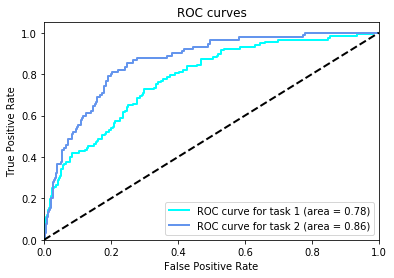

Category 1 Score: 0.779
Category 2 Score: 0.859
Category 3 Score: 0.819
------------------------------------------------------------------
Confusion matrix for Melanoma
Best threshold: 0.12


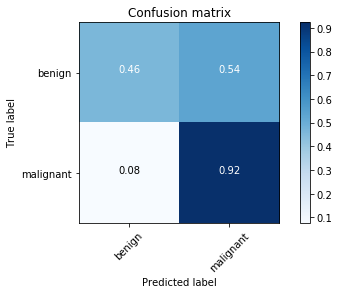

------------------------------------------------------------------
Confusion matrix for Seborrheic keratoses
Best threshold: 0.14


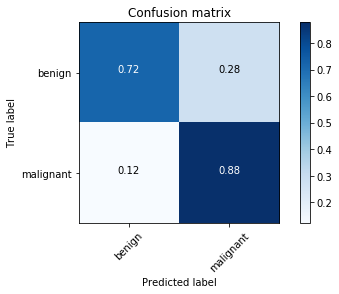

In [102]:
import numpy as np
import pandas as pd
from get_results import plot_roc_auc, plot_confusion_matrix
from results_helper import plot_best_confusion_matrix

y_true = get_predictions('ground_truth.csv')
predictions = get_predictions('predictions.csv', 2)

plot_roc_auc(y_true, predictions)

for i, disease in enumerate(['Melanoma', 'Seborrheic keratoses']):
    print('------------------------------------------------------------------')
    print('Confusion matrix for ' + disease)
    plot_best_confusion_matrix(y_true[:, i], predictions[:, i], costs=(1,10))

# Conclusions

In a few hours, I was able to achieve a Mean ROC AUC score of 0.819. That would have been the 15th place in the initial challenge (see scores below). It's satisfying for what I wanted to achieve in a limited time.

Here are possible points of improvement to reach better results:
- more data augmentations techniques: randomly shift image, randomly convert image to grayscale...
- find more images: 2000 images is not a lot, I could download more images from [ISIC Archive](https://isic-archive.com/#images)
- try different architecture of the classifier
- try to unfreeze and then continue to train the features so that the feature detection adapts itself to skin diseases
- give a try to other transfer learning models : resnet, vgg16, Inception v3... 
- fine tune learning rate and other optimizer hyper parameters to speed up gradient descent
- give a try to other optimizers: AdaGrad, RMSProp, Adamax, Adadelta...
- train for more epochs as validation loss is still decreasing
- try different batch_size to see how it impacts training 
- display images where the model fails to understand why it fails and maybe improve algorithm, data augmentation

![title](images/cat_3.png)